In [1]:
from typing import Any, Dict, Iterable, Sequence, Tuple, Optional, Union
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from pathlib import Path
from scipy import ndimage
import torch
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

# Importing my own function from external file
from patient_data_split import pat_train_test_split

In [2]:
%matplotlib inline

In [3]:
def removeSmallScans(info, img_path, img_dim, thresh):
    """
    Filtering out CT scans with tumour pixel counts below a threshold.

    Args:
            info: pandas.Dataframe, read from CSV, contains image file names, patient ID, slice ID, and RFS time and event labels
                Column titles should be: File, Pat ID, Slice Num, RFS Code, RFS Time
            img_path: string, path to folder containing image files listed in info
            img_dim: int, dimension of images
            thresh: int, amount of image that needs to be tumour pixels to be kept in

    """
    # Get list of image file names
    fnames = np.asarray(info['File'])
    # Initialize array to store the non-zero area of each image
    non_zeros = np.zeros(len(fnames))
    # original index list
    o_idx = list(range(len(fnames)))

    for idx, name in enumerate(fnames):
        img = np.fromfile(img_path + str(name))
        img = np.reshape(img, (img_dim, img_dim))

        # Making a mask for the tumour vs. background??
        # Makes any non-background pixels = 1 (image is now binary)
        binImg = (img != 0).astype(float)
        # Fill in any holes that are within the tumour
        binImg = ndimage.binary_fill_holes(binImg).astype(float)

        area = np.count_nonzero(binImg)
        non_zeros[idx] = area
        # print(area)

    # Indices to remove that have a total area of interest below the threshold
    r_idx = np.asarray(np.where((non_zeros < thresh))).squeeze()
    # New indices
    n_idx = np.delete(o_idx, r_idx)
    # print(len(r_idx))

    return n_idx

In [44]:
# Constants for development
FILESTOLOAD = 500 # 2888 is all of them
imdim = 256 # must match opt.ImageSize in image preprocessing configuration files
train_valid_split = 0.8 # where to split data for training and validation
random_seed = 16 # used in train-validation splitting
dropout_seed = 16 # used in dropout layers in kt_model
scanthresh = 1000

In [45]:
# Path to CSVs that connect patient id to slices and rfs label
# Mac path
# data_dir = 
# zero_info_path = "/Users/katyscott/Documents/ICC/Data/Labels/" + str(imdim_from_preprocessing) +"/RFS_all_tumors_zero.csv"
# Linux path 
data_dir = '/media/katy/Data/ICC/Data'

# Get paths to images and labels
info_path = os.path.join(data_dir, 'Labels', str(imdim), 'RFS_gene_tumors_zero.csv')
z_img_path = os.path.join(data_dir, 'Images/Tumors', str(imdim), 'Zero/')

info = pd.read_csv(info_path)

# Fixing columns with illegal characters in the name
info.rename(columns={'CDKN2A.DEL': 'CDKN2A_DEL', 'TGF-Beta_Pathway': 'TGF_Beta_Pathway'}, inplace=True)

# Filter scans with mostly background in the image
filtered_indices = removeSmallScans(info, z_img_path, imdim, scanthresh)
filtered_info = info.iloc[filtered_indices]

In [46]:
image_fnames = np.asarray(filtered_info.iloc[:, 0])
pat_num = np.asarray(filtered_info.iloc[:, 1])
slice_num = np.asarray(filtered_info.iloc[:, 2])
rfs_event = np.asarray(filtered_info.iloc[:, 3])
rfs_time = np.asarray(filtered_info.iloc[:, 4])

# Confirming loading in happened correctly
print("Total label count:", rfs_event.shape)
print("First RFS time label:", rfs_time[0])

Total label count: (1320,)
First RFS time label: 0.6


In [47]:
#Loading images

images = np.empty((1, imdim, imdim))
file_count = 0
for image_file in tqdm(image_fnames):
    if file_count >= FILESTOLOAD:
        break
    else:
        file_count += 1
        # Load in file as numpy array
        img = np.fromfile(z_img_path + image_file)
        # Reshape image from 1D to 2D array
        img_2D = np.reshape(img, (imdim, imdim))
        # Add third dimension so image can be appended to main images array
        img_final_3D = np.reshape(img_2D, (1,) + img_2D.shape)
        images = np.append(images, img_final_3D, axis=0)

images = np.delete(images, 0, axis=0)

 38%|███▊      | 500/1320 [00:11<00:18, 43.43it/s] 


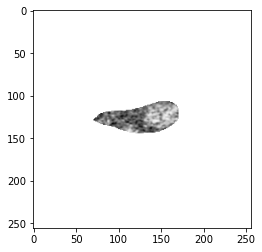

In [8]:
plt.figure()
plt.imshow(images[0], cmap='Greys')
plt.show()

<Figure size 432x288 with 0 Axes>

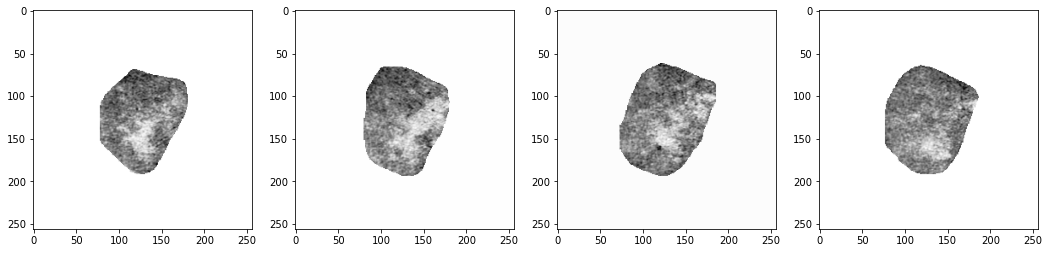

In [43]:
index = 480
plt.figure()

f, axarr = plt.subplots(1,4, figsize=(18,18))


axarr[0].imshow(images[index], cmap='Greys')
axarr[1].imshow(images[index+1], cmap='Greys')
axarr[2].imshow(images[index+2], cmap='Greys')
axarr[3].imshow(images[index+3], cmap='Greys')

plt.show()

In [ ]:
index = 0 
plt.imshow(images[index], cmap='Greys')
plt.show()